# Versatile Detector of Pseudo-periodic Patterns

This notebook was based on a matlab script coded by A. Santini, M. Llamedo Soria and E. Diez. You can view the project in this link.

https://github.com/marianux/ecg-kit/blob/be4410b70341c6d3c1439f9101491c5446b74944/common/aip_detector.m

Further information:
"Versatile Detector of Pseudo-periodic Patterns"
http://www.cinc.org/archives/2018/pdf/CinC2018-379.pdf

Jorge López Luna da Silva, UTN FRBA

### Introduction:
On this document, we will use the matlab code and I'll try to explain it easily, how does it work, its parameters and the expected results. Math operations will be  described too.

### ¿What is an ECG?

An ECG (electrocardiogram) is a time dependent graphic representation of electrical activity on cardiac muscles.
The next image represents the ECG wave:

<img src="files/ECG_Ondas.svg">

### ¿Why an ECG is important?

If we analize morphology and frequency of certain patterns, we will be able to determinate cardiac pathologies. Nowadays, ECG analysis represents a way of detecting ischemia and heart attacks before the happen.
With the aip_detector algorithm, we expect to obtain a vector where R points are ubicated.

### Let's start with the code:

First, we load a real ECG from an open source database provided by:

https://physionet.org/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import scipy
from scipy.signal import lfilter
from scipy.signal import find_peaks

# Load the ECG
da , info = wfdb.rdsamp( '100', pb_dir='mitdb/', sampfrom=0 , channels=[0])
data = pd.DataFrame({'hart':da[:,0]})

# Here the ecg is shown on a window
plt.figure()
plt.title("ECG")
plt.plot(data, alpha=1, color='blue')
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([-0.75,1.2])
plt.xlabel('Samples')
plt.ylabel('V')
plt.show()
    


<Figure size 640x480 with 1 Axes>

### Beginning of the algorithm:

First, the authors proposed a pattern signal like this:

$ p(n) = g(n).\frac{dg(n)}{dn} $ 

With g(n) as a gaussian wave.

$ g(n) = e^{\frac{-[n-(N/2)]²}{2\varsigma²}} $

N: pattern and g(n) length.

$ \varsigma = \frac{N-1}{5}$ 

Why are we using that function? Because it is an easy way of creating an arbitrary pattern with impulsive content and a "soft". In other words, a band pass signal.

As shown in the paper, a variation in the width (time domain), will increase the selectivity (frequency domain):

<img src="files/Patron.png">     <img src="files/Patron_2.png">  

So, multiplying the ECG with the pattern and then integrating, QRS complex will increase its amplitude. On the other hand, T wave will decrease. That's exactily the same as convolving. 

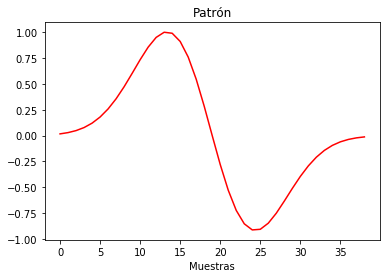

In [2]:

# N is the pattern width
N = 40

# g(n) : Gaussian function
sigma = (N-1)/5
g = scipy.signal.gaussian( N , ((N-1)/5) )

# Pattern:  p = dg * g
dg = np.diff(g)
g = g[1:]    # Delete last element
p = dg*g

# Normalize_pattern = true
maxim = np.max(np.abs(p))   
p = p/maxim

# Show pattern
plt.figure()
plt.title("Patrón")
plt.plot(p, alpha=1, color='red')
axes = plt.gca()
plt.xlabel('Muestras')
plt.show()

### Detection signal:
The algorithm continues  with the detection signal analysis, based on this ecuation:
<img src="files/señal_det.png">  

s(i): detection signal

What does it mean?
In signal processing, it will be the same as a "matched filter", which is obtained by correlating a known signal with a certain delay, with the pattern inverted in time.


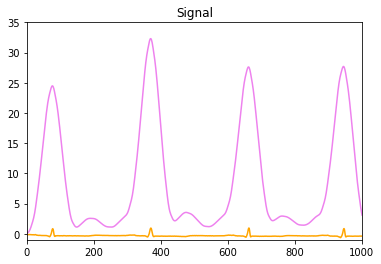

In [3]:
# Filtering 
s = np.array(data['hart'])
rise_det = lfilter( p , 1 , np.flip(s))
rise_det = lfilter( p , 1 , np.flip(rise_det))

# Low Pass filter
example = 120e-3
pattern_size = 2*np.round(example/2*info['fs'])+1
lp_size = np.round(1.2*pattern_size)  
vector = np.ones(int(lp_size))
vector = vector/lp_size
rise_det = lfilter( vector, 1, np.flip(np.abs(rise_det)) )
rise_det = lfilter( vector, 1, np.flip(rise_det) )

# Show the result
plt.figure()
plt.title("Signal")
plt.plot(rise_det, alpha=1, color='violet')
plt.plot(s, alpha=1, color='orange')
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-1,35])
plt.show()

### 1° Threshold
In order to obtain the R points vector, we use the "percentile" function. If we select, for example, a threshold of 30, we will get the threshold in wich 30% of samples are contained.
Finally, using "find peaks" (function library), we obtain the local maxims.


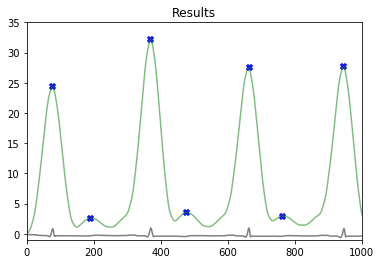

In [8]:
initial_thr = 30
actual_thr = np.percentile(rise_det, initial_thr)  
peaks_loc, _ = find_peaks(rise_det, height=actual_thr)
     
plt.figure()
plt.title("Results")
plt.plot(rise_det, alpha=0.5, color='green')
plt.plot(s, alpha=0.5, color='black')
axes = plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([-1,35])
plt.scatter(peaks_loc,rise_det[peaks_loc], alpha=0.9, color='blue', marker="X")
plt.show()

### 2° Threshold
The next step is to calculate the 2° threshold by using statistical tools.So, we generate an histogram wich shows the distribution of our equiespaced data. Steps were calculated as:

<img src="files/histo1.png">  


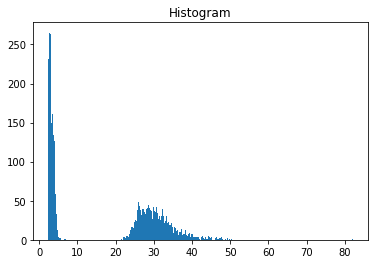

In [5]:
# Histogram
q = list(range(1,100))
prctile_grid = np.percentile(rise_det[peaks_loc],q)
grid_step = np.median(np.diff(prctile_grid))
max_values = np.max(rise_det[peaks_loc])
thr_grid = np.arange(actual_thr,max_values,grid_step)
hist_max_values,a = np.histogram(rise_det[peaks_loc],thr_grid)

plt.figure()
plt.title("Histogram")
plt.hist(rise_det[peaks_loc],bins = len(thr_grid))
plt.show()

### Computating the last threshold

It is calculated by selecting the max. value that meets the following condition:

<img src="files/umbral2.png"> 

<img src="files/f.png">

c(r) is our hb local max. value. f(r) is the c(r) index.

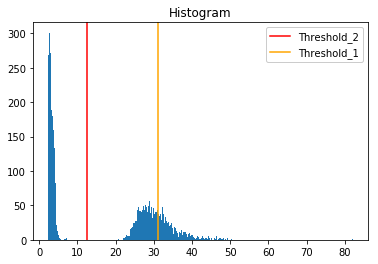

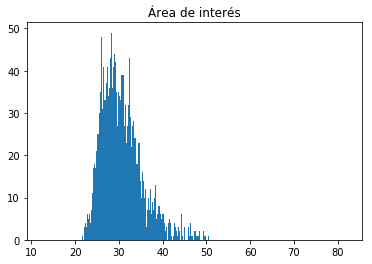

In [6]:
# Statistical threshold
first_bin_idx = 1
thr_idx = find_peaks(hist_max_values)
thr_max = hist_max_values[thr_idx[0]]
thr_idx_expected = np.floor(np.dot(thr_idx[0],thr_max) *(1/np.sum(thr_max)))
aux_seq = np.array(range(1,len(thr_grid)))
hist_max_values = hist_max_values[aux_seq < thr_idx_expected]
min_hist_max_values = np.min(hist_max_values)
aux_seq = aux_seq[ aux_seq < thr_idx_expected ]
aux_seq = aux_seq[ aux_seq >= first_bin_idx ]
thr_min_idx = np.round(np.mean(np.nonzero(aux_seq & hist_max_values == min_hist_max_values)))
actual_thr = thr_grid[int(thr_min_idx)]
thr_grid = np.arange(actual_thr,max_values,grid_step)

# Here we plot the thresholds on the histogram
plt.figure()
plt.title("Histogram")
plt.hist(rise_det[peaks_loc],bins = len(thr_grid))
plt.axvline(x=actual_thr, color = 'red', label = 'Threshold_2')
plt.axvline(x=thr_grid[int(thr_idx_expected)], color = 'orange', label = 'Threshold_1')
plt.legend(framealpha=1, frameon=True);
plt.figure()
plt.title("Área de interés")
plt.hist(rise_det[peaks_loc],bins = thr_grid)
plt.show()

### Results
Once we obtain Una vez calculado el umbral en cuestión, procedemos a filtrar los picos para quedarnos con los máximos deseados.

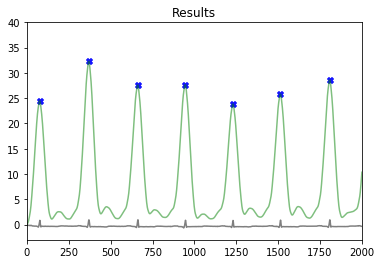

In [7]:
# Final results
peaks_loc, _ = find_peaks(rise_det, height=actual_thr)
plt.figure()
plt.title("Results")
plt.plot(rise_det, alpha=0.5, color='green')
plt.plot(s, alpha=0.5, color='black')
plt.scatter(peaks_loc,rise_det[peaks_loc], alpha=0.9, color='blue', marker="X")
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([-3,40])
plt.show()